In [20]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

In [21]:
dataset_name = "beans"
(ds_train, ds_test, ds_val), ds_info = tfds.load(
    dataset_name, split=["train", "test", "validation"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [22]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

2024-09-08 08:33:04.023104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


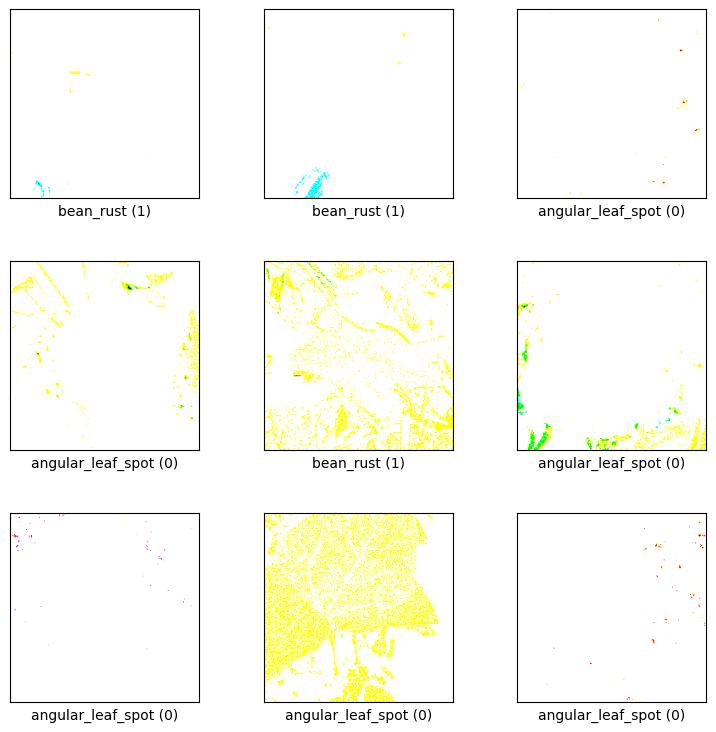

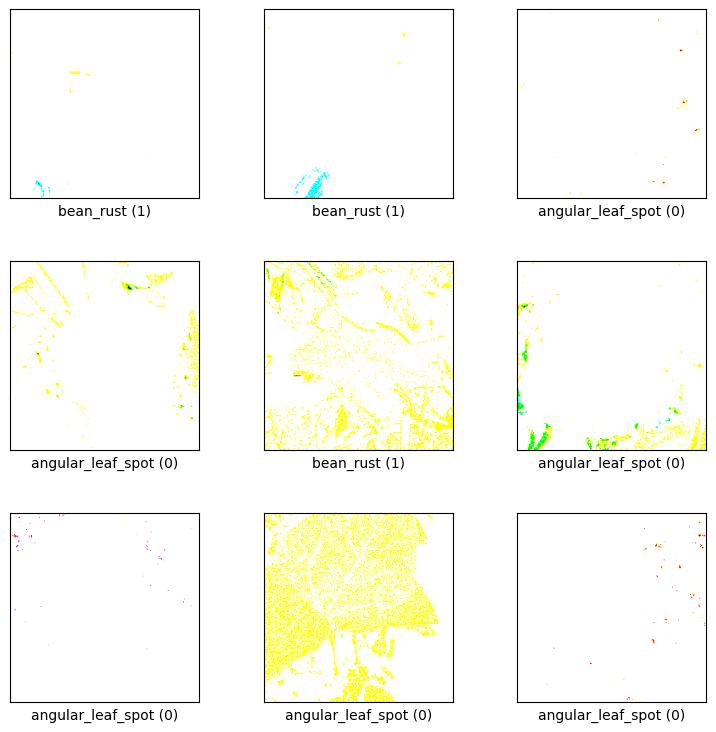

In [44]:
tfds.visualization.show_examples(ds=ds_train,  ds_info = ds_info )

2024-09-08 08:30:19.217470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


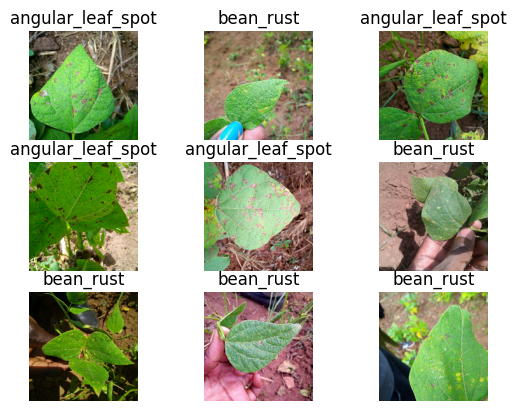

In [42]:

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label


label_info = ds_info.features["label"]
suffle_ds = ds_train.shuffle(10)
for i, (image, label) in enumerate(suffle_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(format_label(label))
    plt.axis("off")

In [45]:
beansImages = {}
label_info = ds_info.features["label"]
for label_name in label_info.names:
    beansImages[label_name] = []
for i, (image, label) in enumerate(ds_train):
    beansImages[format_label(label)].append(image)
for label_name in label_info.names:
    print (f"Total of {label_name} leaves: {len(beansImages[label_name])}")

Total of angular_leaf_spot leaves: 345
Total of bean_rust leaves: 348
Total of healthy leaves: 341


2024-09-08 08:35:00.390559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


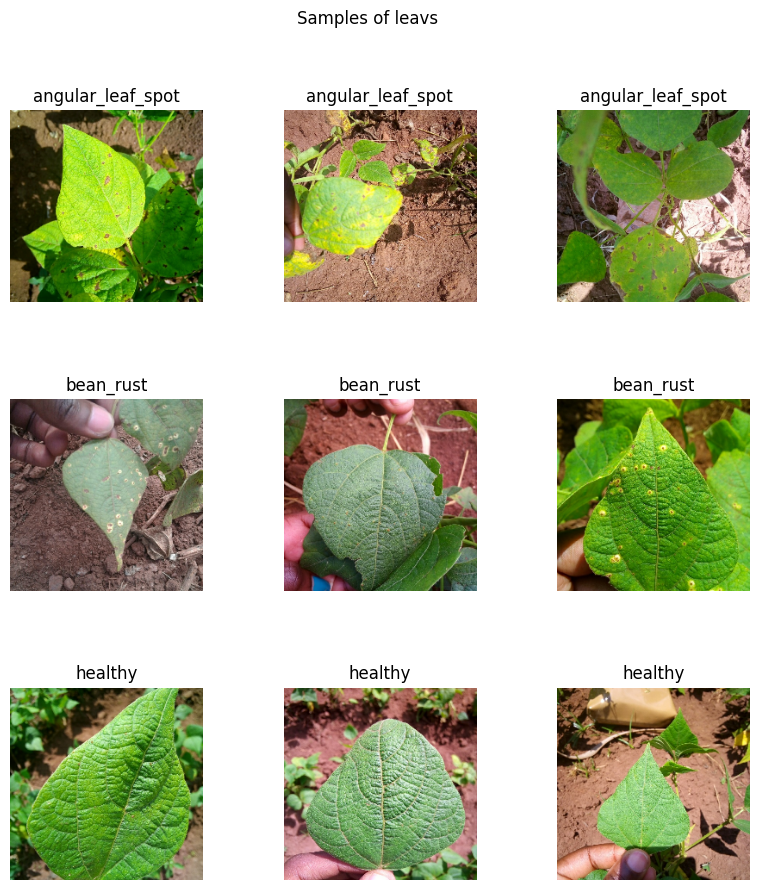

In [49]:
import random

def plot_sample_images():
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Samples of leavs')
    for i, label in enumerate(beansImages.keys()):
        for j in range(3):
            randeom_index = random.randint(0, len(beansImages[label]) -1)	
            img = beansImages[label][randeom_index].numpy().astype("uint8")
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(label)
    plt.show()
plot_sample_images()

In [50]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [52]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [53]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 0.3453 - loss: 4.4315 - val_accuracy: 0.3359 - val_loss: 1.1887
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.3429 - loss: 3.0429 - val_accuracy: 0.3359 - val_loss: 1.1593
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.3220 - loss: 1.9713 - val_accuracy: 0.3281 - val_loss: 1.1366
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.3445 - loss: 1.7387 - val_accuracy: 0.3359 - val_loss: 1.2573
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.3948 - loss: 2.2062 - val_accuracy: 0.3359 - val_loss: 1.0986
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.4702 - loss: 1.4132 - val_accuracy: 0.3281 - val_loss: 1.2839
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.4877 - loss: 1.5983 - val_accuracy: 0.3359 - val_loss: 1.2607
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.5264 - loss: 1.2832 - val_accuracy: 0.3359 - val_loss

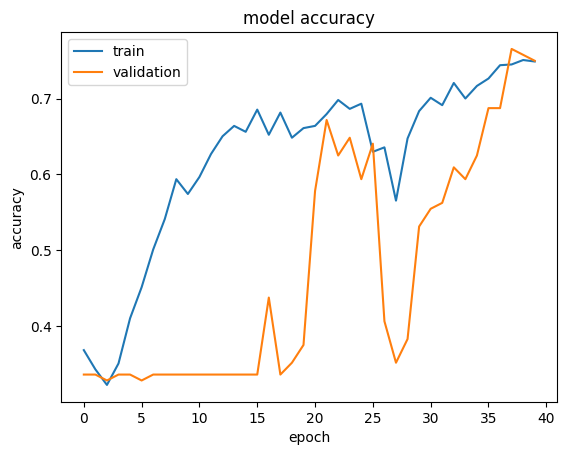

In [54]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [55]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5809 - loss: 1.4236 - val_accuracy: 0.7188 - val_loss: 0.6315
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8304 - loss: 0.5628 - val_accuracy: 0.8672 - val_loss: 0.3993
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8393 - loss: 0.5057 - val_accuracy: 0.7969 - val_loss: 0.4391
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8610 - loss: 0.4471 - val_accuracy: 0.7891 - val_loss: 0.4737
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8307 - loss: 0.6306 - val_accuracy: 0.8438 - val_loss: 0.4006
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8755 - loss: 0.4861 - val_accuracy: 0.8359 - val_loss: 0.4477
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8623 - loss: 0.4607 - val_accuracy: 0.8750 - val_loss: 0.3312
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8654 - loss: 0.4486 - val_accuracy: 0.8203 - val_loss:

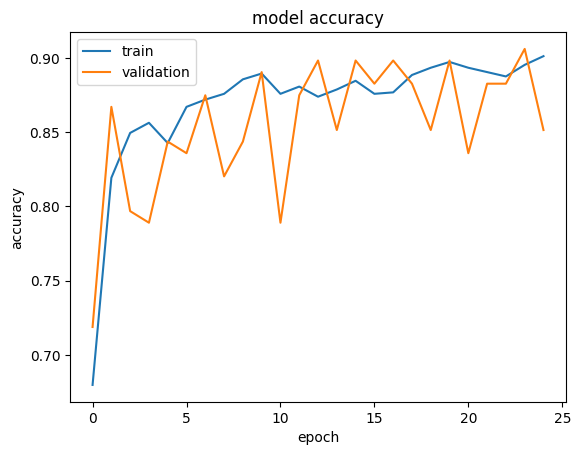

In [56]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)